In [ ]:
#Connect to Opticstudio
import clr, os, winreg
from itertools import islice

#READ ME
#For the following to function, you MUST have your optics file open in Optic Studio, and
#you MUST go to "Programming" and then click on "Interactive Extension", then run the
#python program.

# determine the Zemax working directory
aKey = winreg.OpenKey(winreg.ConnectRegistry(None, winreg.HKEY_CURRENT_USER), r"Software\Zemax", 0, winreg.KEY_READ)
zemaxData = winreg.QueryValueEx(aKey, 'ZemaxRoot')
NetHelper = os.path.join(os.sep, zemaxData[0], r'ZOS-API\Libraries\ZOSAPI_NetHelper.dll')
winreg.CloseKey(aKey)

# add the NetHelper DLL for locating the OpticStudio install folder
clr.AddReference(NetHelper)
import ZOSAPI_NetHelper

pathToInstall = ''
# uncomment the following line to use a specific instance of the ZOS-API assemblies
#pathToInstall = r'C:\C:\Program Files\Zemax OpticStudio'

# connect to OpticStudio
success = ZOSAPI_NetHelper.ZOSAPI_Initializer.Initialize(pathToInstall)

zemaxDir = ''
if success:
    zemaxDir = ZOSAPI_NetHelper.ZOSAPI_Initializer.GetZemaxDirectory()
    print('Found OpticStudio at:   %s' + zemaxDir)
else:
    raise Exception('Cannot find OpticStudio')

# load the ZOS-API assemblies
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI.dll'))
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI_Interfaces.dll'))
import ZOSAPI

TheConnection = ZOSAPI.ZOSAPI_Connection()
if TheConnection is None:
    raise Exception("Unable to intialize NET connection to ZOSAPI")

TheApplication = TheConnection.ConnectAsExtension(0)
if TheApplication is None:
    raise Exception("Unable to acquire ZOSAPI application")

if TheApplication.IsValidLicenseForAPI == False:
    raise Exception("License is not valid for ZOSAPI use.  Make sure you have enabled 'Programming > Interactive Extension' from the OpticStudio GUI.")

TheSystem = TheApplication.PrimarySystem
if TheSystem is None:
    raise Exception("Unable to acquire Primary system")

print('Connected to OpticStudio')
####################################################################################################

#Program Setup
import numpy as np
import scipy
import scipy.io as scipyio
import sys, time
import matplotlib.pyplot as plt
from astropy.io import fits
import csv
import math as m

def transpose(data):
    """Transposes a 2D list (Python3.x or greater).  
    
    Useful for converting mutli-dimensional line series (i.e. FFT PSF)
    
    Parameters
    ----------
    data      : Python native list (if using System.Data[,] object reshape first)    
    
    Returns
    -------
    res       : transposed 2D list
    """
    if type(data) is not list:
        data = list(data)
    return list(map(list, zip(*data)))
    
def reshape(data, x, y, transpose = False):
    """Converts a System.Double[,] to a 2D list for plotting or post processing
    
    Parameters
    ----------
    data      : System.Double[,] data directly from ZOS-API 
    x         : x width of new 2D list [use var.GetLength(0) for dimension]
    y         : y width of new 2D list [use var.GetLength(1) for dimension]
    transpose : transposes data; needed for some multi-dimensional line series data
    
    Returns
    -------
    res       : 2D list; can be directly used with Matplotlib or converted to
                a numpy array using numpy.asarray(res)
    """
    if type(data) is not list:
        data = list(data)
    var_lst = [y] * x;
    it = iter(data)
    res = [list(islice(it, i)) for i in var_lst]
    if transpose:
        return self.transpose(res);
    return res
  
def Rx(deg):
    theta = deg * m.pi/180
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
  
def Ry(deg):
    theta = deg * m.pi/180
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
  
def Rz(deg):
    theta = deg * m.pi/180
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

##STAR Setup
analysis = TheSystem.Analyses
tools = TheSystem.Tools
surf_inds = [3,13,18,24,29,33,37,42,46,49]
surf_inds_old = [3,8,13,18,23,27,31,36,40,44]
surf_names = ['M1','M2','M3','LODM','Dicro','OAP1','OAP2','BMC','OAP3','VVC']
n_surf = len(surf_inds)

In [ ]:
##Setup
data_dir = 'c:\\Users\\locsst\\Desktop\\PICTURE_STOP_Rev2\\ansys\\STAR\\pm\\' 
mf_dir = 'c:\\Users\\locsst\\Documents\\Zemax\\MeritFunction\\'
nsteps = 72

TheLDE = TheSystem.LDE
move_m2 = TheLDE.GetSurfaceAt(7)
lodm_phase = TheLDE.GetSurfaceAt(surf_inds[3]-1)
surf_vvc = TheLDE.GetSurfaceAt(surf_inds[n_surf-1])

chief_arr = np.zeros((n_surf,3,nsteps))
bwalk = np.zeros((n_surf,3,nsteps))
rdisp = np.zeros((n_surf,3,nsteps))
rot_surf = np.zeros((n_surf,3,nsteps))

disp_arr = np.zeros((n_surf,3,nsteps))
global_conv = np.zeros((3,3,n_surf))

nominal_chief_arr = np.zeros((n_surf,3))
zern_amp = np.zeros((nsteps,12))

ray_vecs = np.zeros((3,3,nsteps))

wf = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
wfsettings = wf.GetSettings()
wfsettings.set_RemoveTilt(True)
wfsettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_512x512
wfsettings.ShowAs = ZOSAPI.Analysis.Settings.Wavefront.FoucaultShowAs.FalseColor

wf.ApplyAndWaitForCompletion()
wfresults = wf.GetResults()
wfgrid = wfresults.GetDataGrid(0).Values
wfsize = [wfgrid.GetLength(0),wfgrid.GetLength(1)]

wfcube = np.zeros((wfsize[0],wfsize[1],nsteps))

In [ ]:
##Clear Any Leftover STAR Data from previous runs, reset variables
for i in range(n_surf):
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.UnloadData()

move_m2.ThicknessCell.set_DoubleValue(0)
move_m2.GetCellAt(12).set_DoubleValue(0)
move_m2.GetCellAt(13).set_DoubleValue(0)
move_m2.GetCellAt(14).set_DoubleValue(0)
move_m2.GetCellAt(15).set_DoubleValue(0)

lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).set_DoubleValue(0)
lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).set_DoubleValue(0)

#Get data from nominal system
for i in range(n_surf):
    nominal_chief_arr[i,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, surf_inds[i],0,0,0,0,0,0,0)
    nominal_chief_arr[i,1] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, surf_inds[i],0,0,0,0,0,0,0)
    nominal_chief_arr[i,2] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, surf_inds[i],0,0,0,0,0,0,0)

    for j in range(9):
        #LOCAL TO GLOBAL rotation matrix
        global_conv[m.floor(j / 3), j % 3, i] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.GLCR, surf_inds[i],j+1,0,0,0,0,0,0)
    
    #global_conv[:,:,i] = np.linalg.inv(global_conv[:,:,i])

#Get initial refernce point for VVC
vvc_x0 = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0)
vvc_y0 = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0)

wf.ApplyAndWaitForCompletion()
print(nominal_chief_arr[i,:])

In [ ]:
##Run initial timestep
for i in range(n_surf):
    disp_file = data_dir + '00_Timestep_00001_20240318' + '\\Surface_' + str(surf_inds_old[i]).zfill(2) + '_Deformation.txt'
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.SetDataIsGlobal()
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.Fits.Settings.SetAllValues(2,2,2,10,10**(-9),0.5)
    
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.ImportDeformations(disp_file)
    
wf.ApplyAndWaitForCompletion()

In [ ]:
for i in range(n_surf):
    surf_tmp = TheLDE.GetSurfaceAt(surf_inds[i])
    surf_tmp.STARData.Deformations.RBMs.GetTransformValues()
    disp_surf = np.asarray([surf_tmp.STARData.Deformations.RBMs.Decenters.X,\
      surf_tmp.STARData.Deformations.RBMs.Decenters.Y,\
      surf_tmp.STARData.Deformations.RBMs.Decenters.Z,\
      surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Alpha,\
      surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Beta,\
      surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Gamma])

    print(surf_names[i],25.4 * disp_surf)


In [ ]:
##Apply Secondary Correction
tools.RemoveAllVariables()

move_m2.ThicknessCell.MakeSolveVariable()
move_m2.GetCellAt(12).MakeSolveVariable()
move_m2.GetCellAt(13).MakeSolveVariable()
move_m2.GetCellAt(14).MakeSolveVariable()
move_m2.GetCellAt(15).MakeSolveVariable()

#Load OPD Merit Function
TheSystem.MFE.LoadMeritFunction(mf_dir + 'opd.mf')

#Find location of the vvc vertex (0th approx)
surf_vvc.STARData.Deformations.RBMs.GetTransformValues()
vvc_dxg = surf_vvc.STARData.Deformations.RBMs.Decenters.X
vvc_dyg = surf_vvc.STARData.Deformations.RBMs.Decenters.Y
vvc_dzg = surf_vvc.STARData.Deformations.RBMs.Decenters.Z

#Convert to local coords
vvc_disp = np.matmul(np.linalg.inv(global_conv[:,:,n_surf-1]),[vvc_dxg,vvc_dyg,vvc_dzg])
TheSystem.MFE.GetOperandAt(4).set_Target(vvc_x0 + vvc_disp[0])
TheSystem.MFE.GetOperandAt(5).set_Target(vvc_y0 + vvc_disp[1])

LocalOpt = TheSystem.Tools.OpenLocalOptimization()
if (LocalOpt != None):

    LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
    LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Infinite
    LocalOpt.NumberOfCores = 32
    print('Initial Merit Function ', LocalOpt.InitialMeritFunction)
    
    LocalOpt.RunAndWaitWithTimeout(15)
    LocalOpt.Cancel()
    LocalOpt.WaitForCompletion()
    print('Intermediate Merit Function: ', LocalOpt.CurrentMeritFunction)

    LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
    LocalOpt.RunAndWaitWithTimeout(30)
    LocalOpt.Cancel()
    LocalOpt.WaitForCompletion()
    print('Final Merit Function: ', LocalOpt.CurrentMeritFunction)
    
    LocalOpt.Close()

HammerOpt = TheSystem.Tools.OpenHammerOptimization()
if (HammerOpt != None):
    print('Hammering...')
    HammerOpt.Algorithm =  ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
    HammerOpt.NumberOfCores = 32
    HammerOpt.RunAndWaitWithTimeout(60)
    HammerOpt.Cancel()
    HammerOpt.WaitForCompletion()
    print('Final Merit Function: ', HammerOpt.CurrentMeritFunction)

    HammerOpt.Close()

xdev = 2.54*(10**4)*(vvc_x0 + vvc_disp[0]-TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[n_surf-1],0,0,0,0,0,0,0))
ydev = 2.54*(10**4)*(vvc_y0 + vvc_disp[1]-TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[n_surf-1],0,0,0,0,0,0,0))

print('Approx. Deviation (um): ', np.sqrt(xdev**2 + ydev**2))
wf.ApplyAndWaitForCompletion()

In [ ]:
print(xdev,ydev)
print(vvc_x0 + vvc_disp[0], vvc_y0 + vvc_disp[1])

In [ ]:
##Apply LODM correction to first timestep
tools.RemoveAllVariables()
if 1:
  ##New optimization routine for LODM, since localopt is so slow
  nz = 11
  tol = 10 ** (-6)
  zernikes = np.zeros((nz))


#Tip tilt correction
  lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).MakeSolveVariable()
  lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).MakeSolveVariable()

  TheSystem.MFE.LoadMeritFunction(mf_dir + 'tiptilt.mf')
  TheSystem.MFE.GetOperandAt(1).set_Target(vvc_x0 + vvc_disp[0])
  TheSystem.MFE.GetOperandAt(2).set_Target(vvc_y0 + vvc_disp[1])

  LocalOpt = TheSystem.Tools.OpenLocalOptimization()
  if (LocalOpt != None):
    LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
    LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Infinite
    LocalOpt.NumberOfCores = 32

    loopct = 0
    while LocalOpt.CurrentMeritFunction > 10 * tol:
      LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
      LocalOpt.RunAndWaitWithTimeout(15)
      LocalOpt.Cancel()
      LocalOpt.WaitForCompletion()
      loopct += 1
      if loopct > 2:
        LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
        LocalOpt.RunAndWaitWithTimeout(10)
        LocalOpt.Cancel()
        LocalOpt.WaitForCompletion()
      if loopct > 5:
          break

    print('Final Merit Function for tip/tilt: ', LocalOpt.CurrentMeritFunction)            
    LocalOpt.Close()

  zern_amp[j,0] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).get_Value()
  zern_amp[j,1] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).get_Value()

  #Higher order terms
  TheSystem.MFE.LoadMeritFunction(mf_dir + 'zernike.mf')
  loopct = 0
  a = TheSystem.MFE.CalculateMeritFunction()

  while a > tol:
    a = TheSystem.MFE.CalculateMeritFunction()

    #Get current amplitudes
    zern_amp[j,2] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).get_Value()
    zern_amp[j,3] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).get_Value()
    zern_amp[j,4] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).get_Value()
    zern_amp[j,5] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).get_Value()
    zern_amp[j,6] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).get_Value()
    zern_amp[j,7] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).get_Value()
    zern_amp[j,8] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).get_Value()
    zern_amp[j,9] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).get_Value()
    zern_amp[j,10] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).get_Value()

    for i in range(2,nz):
      zernikes[i] = (0.98 ** loopct) * TheSystem.MFE.GetOperandAt(i+1).get_Value()

    #Set new values (signs were figured out manually)
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).set_DoubleValue(zern_amp[j,2]+zernikes[2])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).set_DoubleValue(zern_amp[j,3]+zernikes[3])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).set_DoubleValue(zern_amp[j,4]+zernikes[4])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).set_DoubleValue(zern_amp[j,5]+zernikes[5])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).set_DoubleValue(zern_amp[j,6]+zernikes[6])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).set_DoubleValue(zern_amp[j,7]+zernikes[7])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).set_DoubleValue(zern_amp[j,8]+zernikes[8])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).set_DoubleValue(zern_amp[j,9]+zernikes[9])
    lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).set_DoubleValue(zern_amp[j,10]+zernikes[10])
    
    loopct += 1
    #Fix any errors with tip and tilt with the optimizer
    if loopct > 15:
        break

  a = TheSystem.MFE.CalculateMeritFunction()
  print('Final Merit Function for Zernikes: ',a)

#Calculate Beamwalk
for i in range(n_surf):
  ##Motion of the beam
  chief_arr[i,0,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, surf_inds[i],0,0,0,0,0,0,0)
  chief_arr[i,1,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, surf_inds[i],0,0,0,0,0,0,0)
  chief_arr[i,2,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, surf_inds[i],0,0,0,0,0,0,0)

  ##Motion of the optic
  #Get normal and ray vector in global coords
  n_vec = np.matmul(global_conv[:,:,i], [TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENA, surf_inds[i],0,0,0,0,0,0,0),\
  TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENB, surf_inds[i],0,0,0,0,0,0,0),\
  TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENC, surf_inds[i],0,0,0,0,0,0,0)])

  r_vec = np.matmul(global_conv[:,:,i], [TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAA, surf_inds[i],0,0,0,0,0,0,0),\
  TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAB, surf_inds[i],0,0,0,0,0,0,0),\
  TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAC, surf_inds[i],0,0,0,0,0,0,0)])

  if i == n_surf-1:
    r_vec = -1 * r_vec

  #Create/normalize surface x,y unit vectors
  #X such that it is perpendicular to global y
  xs = np.matmul(Ry(-90.),[n_vec[0],0,n_vec[2]])
  xs = xs.A1
  xs = xs/np.linalg.norm(xs)
  #and y is z cross x
  ys = np.cross(n_vec,xs)

  #Get pre-reflection vectors in the surface coord system 
  # (skip reflection for transmissive elements)
  if i == n_surf-1:
    xr = np.matmul(Ry(-90),[np.dot(r_vec,np.transpose(xs)), 0, np.dot(n_vec,r_vec)])
    zr = [np.matmul(r_vec,xs), np.matmul(r_vec,ys), np.dot(n_vec,r_vec)]
  else:
    xr = np.matmul(Ry(-90),[np.dot(r_vec,np.transpose(xs)), 0, -np.dot(n_vec,r_vec)])
    zr = [np.dot(r_vec,xs), np.dot(r_vec,ys), -np.dot(r_vec,n_vec)]
  xr = xr.A1
  xr = xr/np.linalg.norm(xr)
  
  yr = np.cross(zr, xr)

  #Ray vectors in global coordinate basis
  xrg = xr[0] * xs + xr[1] * ys + xr[2] * n_vec
  yrg = yr[0] * xs + yr[1] * ys + yr[2] * n_vec
  zrg = zr[0] * xs + zr[1] * ys + zr[2] * n_vec

  ray_vecs[:,:,0] = np.asarray([xrg,yrg,zrg])

  #Get displacement values in global coords
  surf_tmp = TheLDE.GetSurfaceAt(surf_inds[i])
  surf_tmp.STARData.Deformations.RBMs.GetTransformValues()

  disp_surf = np.asarray([surf_tmp.STARData.Deformations.RBMs.Decenters.X,\
    surf_tmp.STARData.Deformations.RBMs.Decenters.Y,\
    surf_tmp.STARData.Deformations.RBMs.Decenters.Z])
    
  rot_surf[i,:,0] = np.asarray([surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Alpha,\
    surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Beta,\
    surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Gamma])

  ##Get ray motion in global coords
  tmp_disp = (chief_arr[i,:,0] - nominal_chief_arr[i,:])
  bwalk_glob = disp_surf - tmp_disp

  #Get final beamwalk in ray coordinate system
  bwalk[i,:,0] = [np.dot(bwalk_glob,xrg),np.dot(bwalk_glob,yrg),np.dot(bwalk_glob,zrg)]
  rdisp[i,:,0] = [np.dot(disp_surf,xrg),np.dot(disp_surf,yrg),np.dot(disp_surf,zrg)]

wf.ApplyAndWaitForCompletion()
wfresults = wf.GetResults()
wfgrid = wfresults.GetDataGrid(0).Values
wfarr = reshape(wfgrid,wfgrid.GetLength(0),wfgrid.GetLength(1))

wfcube[:,:,0] = wfarr

print(25400 * bwalk[i,:,0])

In [ ]:
for j in range(1,nsteps):
    print(f'Timestep: {str(j)} of {str(nsteps-1)}')

    for i in range(n_surf):
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.UnloadData()
    
    #Open displacement data
    for i in range(n_surf):
        disp_file = data_dir + str(j).zfill(2) + '_Timestep_0'+str(j).zfill(2)+'00_20240318' + '\\Surface_' + str(surf_inds_old[i]).zfill(2) + '_Deformation.txt'
        TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.ImportDeformations(disp_file)

    #Find location of the vvc vertex
    surf_vvc.STARData.Deformations.RBMs.GetTransformValues()
    vvc_dxg = surf_vvc.STARData.Deformations.RBMs.Decenters.X
    vvc_dyg = surf_vvc.STARData.Deformations.RBMs.Decenters.Y
    vvc_dzg = surf_vvc.STARData.Deformations.RBMs.Decenters.Z

    #Convert to local coords
    vvc_disp = np.matmul(np.linalg.inv(global_conv[:,:,n_surf-1]),[vvc_dxg,vvc_dyg,vvc_dzg])

    #Tip tilt correction
    TheSystem.MFE.LoadMeritFunction(mf_dir + 'tiptilt.mf')
    TheSystem.MFE.GetOperandAt(1).set_Target(vvc_x0 + vvc_disp[0])
    TheSystem.MFE.GetOperandAt(2).set_Target(vvc_y0 + vvc_disp[1])

    if 1:
        LocalOpt = TheSystem.Tools.OpenLocalOptimization()
        if (LocalOpt != None):
            LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
            LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Infinite
            LocalOpt.NumberOfCores = 32

            loopct = 0
            while LocalOpt.CurrentMeritFunction > 10 * tol:
                LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
                LocalOpt.RunAndWaitWithTimeout(15)
                LocalOpt.Cancel()
                LocalOpt.WaitForCompletion()
                loopct += 1
                if loopct > 2:
                    LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
                    LocalOpt.RunAndWaitWithTimeout(10)
                    LocalOpt.Cancel()
                    LocalOpt.WaitForCompletion()
                if loopct > 5:
                    break

        print('Final Merit Function for tip/tilt: ', LocalOpt.CurrentMeritFunction)            
        LocalOpt.Close()

        zern_amp[j,0] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par16).get_Value()
        zern_amp[j,1] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par17).get_Value()

        #Higher order terms
        TheSystem.MFE.LoadMeritFunction(mf_dir + 'zernike.mf')
        loopct = 0
        a = TheSystem.MFE.CalculateMeritFunction()

        while a > tol:
            a = TheSystem.MFE.CalculateMeritFunction()

            #Get current amplitudes
            zern_amp[j,2] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).get_Value()
            zern_amp[j,3] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).get_Value()
            zern_amp[j,4] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).get_Value()
            zern_amp[j,5] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).get_Value()
            zern_amp[j,6] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).get_Value()
            zern_amp[j,7] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).get_Value()
            zern_amp[j,8] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).get_Value()
            zern_amp[j,9] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).get_Value()
            zern_amp[j,10] = lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).get_Value()

            for i in range(2,nz):
                zernikes[i] = (0.98 ** loopct) * TheSystem.MFE.GetOperandAt(i+1).get_Value()

            #Set new values (signs were figured out manually)
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par18).set_DoubleValue(zern_amp[j,2]+zernikes[2])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par19).set_DoubleValue(zern_amp[j,3]+zernikes[3])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par20).set_DoubleValue(zern_amp[j,4]+zernikes[4])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par21).set_DoubleValue(zern_amp[j,5]+zernikes[5])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par22).set_DoubleValue(zern_amp[j,6]+zernikes[6])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par23).set_DoubleValue(zern_amp[j,7]+zernikes[7])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par24).set_DoubleValue(zern_amp[j,8]+zernikes[8])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par25).set_DoubleValue(zern_amp[j,9]+zernikes[9])
            lodm_phase.GetSurfaceCell(ZOSAPI.Editors.LDE.SurfaceColumn.Par26).set_DoubleValue(zern_amp[j,10]+zernikes[10])
            
            loopct += 1
            #Fix any errors with tip and tilt with the optimizer
            if loopct > 15:
                break

        a = TheSystem.MFE.CalculateMeritFunction()
        print('Final Merit Function for Zernikes: ',a)
        wf.ApplyAndWaitForCompletion()

    for i in range(n_surf):
        ##Motion of the beam
        chief_arr[i,:,j] = [TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGX, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGY, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RAGZ, surf_inds[i],0,0,0,0,0,0,0)] 
        
        ##Motion of the optic
        #Get normal and ray vector in global coords
        n_vec = np.matmul(global_conv[:,:,i], [TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENA, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENB, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.RENC, surf_inds[i],0,0,0,0,0,0,0)])

        r_vec = np.matmul(global_conv[:,:,i], [TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAA, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAB, surf_inds[i],0,0,0,0,0,0,0),\
        TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAC, surf_inds[i],0,0,0,0,0,0,0)])

        if i == n_surf-1:
            r_vec = -1 * r_vec

        #Create/normalize surface x,y unit vectors
        #X such that it is perpendicular to global y
        xs = np.matmul(Ry(-90.),[n_vec[0],0,n_vec[2]])
        xs = xs.A1
        xs = xs/np.linalg.norm(xs)
        #and y is z cross x
        ys = np.cross(n_vec,xs)

        #Get pre-reflection vectors in the surface coord system 
        # (skip reflection for transmissive elements)
        if i == n_surf-1:
            xr = np.matmul(Ry(-90),[np.dot(r_vec,np.transpose(xs)), 0, np.dot(n_vec,r_vec)])
            zr = [np.matmul(r_vec,xs), np.matmul(r_vec,ys), np.dot(n_vec,r_vec)]
        else:
            xr = np.matmul(Ry(-90),[np.dot(r_vec,np.transpose(xs)), 0, -np.dot(n_vec,r_vec)])
            zr = [np.dot(r_vec,xs), np.dot(r_vec,ys), -np.dot(r_vec,n_vec)]
        xr = xr.A1
        xr = xr/np.linalg.norm(xr)
        
        yr = np.cross(zr, xr)

        #Ray vectors in global coordinate basis
        xrg = xr[0] * xs + xr[1] * ys + xr[2] * n_vec
        yrg = yr[0] * xs + yr[1] * ys + yr[2] * n_vec
        zrg = zr[0] * xs + zr[1] * ys + zr[2] * n_vec

        ray_vecs[:,:,j] = np.asarray([xrg,yrg,zrg])

        #Get displacement values in global coords
        surf_tmp = TheLDE.GetSurfaceAt(surf_inds[i])
        surf_tmp.STARData.Deformations.RBMs.GetTransformValues()
        disp_surf = np.asarray([surf_tmp.STARData.Deformations.RBMs.Decenters.X,\
        surf_tmp.STARData.Deformations.RBMs.Decenters.Y,\
        surf_tmp.STARData.Deformations.RBMs.Decenters.Z])

        rot_surf[i,:,j] = np.asarray([surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Alpha,\
        surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Beta,\
        surf_tmp.STARData.Deformations.RBMs.Rotations.Angles.Gamma])

        ##Get ray motion in global coords
        tmp_disp = (chief_arr[i,:,j] - nominal_chief_arr[i,:])
        bwalk_glob = disp_surf - tmp_disp

        #Get final beamwalk in ray coordinate system
        bwalk[i,:,j] = [np.dot(bwalk_glob,xrg),np.dot(bwalk_glob,yrg),np.dot(bwalk_glob,zrg)]
        rdisp[i,:,j] = [np.dot(disp_surf,xrg),np.dot(disp_surf,yrg),np.dot(disp_surf,zrg)]

    wf.ApplyAndWaitForCompletion()
    wfresults = wf.GetResults()
    wfgrid = wfresults.GetDataGrid(0).Values
    wfarr = reshape(wfgrid,wfgrid.GetLength(0),wfgrid.GetLength(1))

    wfcube[:,:,j] = wfarr

In [ ]:
i = n_surf-1
alpha = np.linalg.norm(bwalk_glob)
local_disp = np.matmul(np.linalg.inv(global_conv[:,:,i]),( disp_surf - alpha * zrg ))
print(local_disp)
print(vvc_disp)

print(25400 * (vvc_disp-local_disp))

In [ ]:
axis = ['X','Y','Z']

tarr = np.zeros(nsteps)
for i in range(nsteps):
    tarr[i] = 5./3 * i

for j in range(3):
    plt.figure()
    plt.title(f'Optic Disp: {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Displacement (um)')

    for i in range(3):
        plt.plot(tarr,2.54*10**4*(rdisp[i,j,:]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
axis = ['X','Y','Z']

tarr = np.zeros(nsteps)
for i in range(nsteps):
    tarr[i] = 5./3 * i

for j in range(3):
    plt.figure()
    plt.title(f'Optic Rotation: {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Rotation (Deg)')

    for i in range(3):
        plt.plot(tarr,(rot_surf[i,j,:]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
zern_amp[55,:]

In [ ]:
i = 55
np.sqrt(zern_amp[i,0]**2 + zern_amp[i,1]**2)
tarr[55]

In [ ]:
axis = ['X','Y','Z']

tarr = np.zeros(nsteps)
for i in range(nsteps):
    tarr[i] = 5./3 * i

for j in range(3):
    plt.figure()
    plt.title(f'AM Beamwalk (No LODM) : {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Beamwalk (um)')

    for i in range(n_surf):
        plt.plot(tarr,2.54*10**4*(bwalk[i,j,:]-bwalk[i,j,0]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
axis = ['X','Y','Z']

tarr = np.zeros(nsteps)
for i in range(nsteps):
    tarr[i] = 5./3 * i

for j in range(3):
    plt.figure()
    plt.title(f'AM Beamwalk (LODM Applied) : {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Beamwalk (um)')

    for i in range(n_surf):
        plt.plot(tarr[1:],2.54*10**4*(bwalk[i,j,1:]-bwalk[i,j,1]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

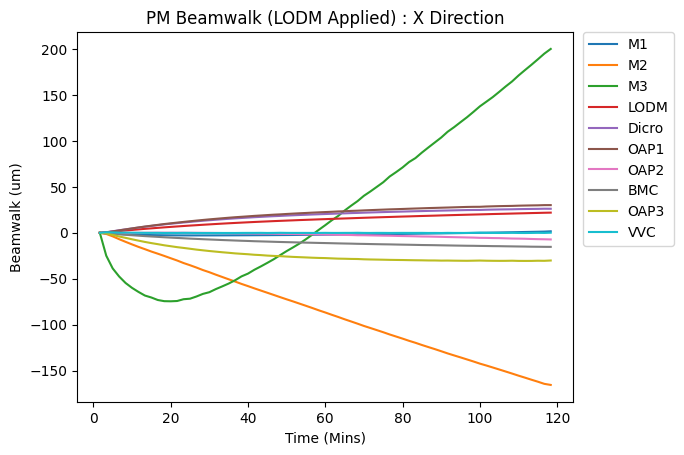

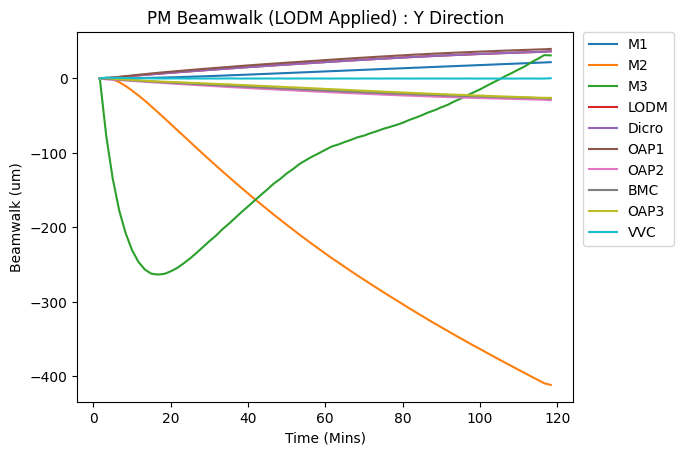

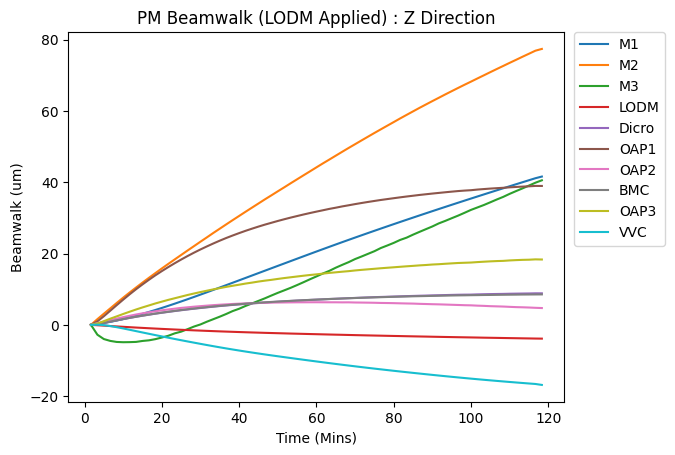

In [13]:
axis = ['X','Y','Z']

tarr = np.zeros(nsteps)
for i in range(nsteps):
    tarr[i] = 5./3 * i

for j in range(3):
    plt.figure()
    plt.title(f'PM Beamwalk (LODM Applied) : {axis[j]} Direction')
    plt.xlabel('Time (Mins)')
    plt.ylabel('Beamwalk (um)')

    for i in range(n_surf):
        plt.plot(tarr[1:],2.54*10**4*(bwalk[i,j,1:]-bwalk[i,j,1]))

    plt.legend(surf_names,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
##Save Data
outdir = 'C:\\Users\\locsst\\Desktop\\PICTURE_STOP_Rev2\\zemax\\data\\'

#Beamwalk 
filename = 'pm_beamwalk.csv'

#Create output array
big_arr = np.zeros((n_surf,2*nsteps+1))
big_arr[:,0] = [1,3,5,7,16,17,19,21,25,29]
for i in range(nsteps):
    big_arr[:,2*i+1] = 0.0254*bwalk[:,0,i]
    big_arr[:,2*i+2]   = 0.0254*bwalk[:,1,i]


with open(outdir+filename,'w',newline = '') as file:
    writen = csv.writer(file)
    writen.writerows(big_arr)

#Wavefront

#Calculate Sampling
r0 = 11.7064 #Primary Clear Radius
pixsize = r0/128 * 0.0254

#Create Header
header = fits.Header()
header['SCALE'] = str(pixsize)
header['UNITS'] = 'meters'

#Convert Data to Meters and write to file
for i in range(nsteps):
    filename = 'am'+str(i+1) + '.fits'
    primary = fits.PrimaryHDU((6 *10**(-7))*wfcube[:,:,i],header=header)
    primary.writeto(outdir + filename, overwrite='True')
